In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix




In [4]:
df = pd.read_csv("diabetes.csv")
print(df.head())


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [5]:
cols_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_to_replace] = df[cols_to_replace].replace(0, np.nan)


In [6]:
df.fillna(df.mean(), inplace=True)


In [7]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [9]:
# Apply SMOTE before scaling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [10]:
# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


In [11]:
# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train_resampled)


RandomForestClassifier(random_state=42)

In [12]:
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7532467532467533
              precision    recall  f1-score   support

           0       0.88      0.72      0.79        99
           1       0.62      0.82      0.70        55

    accuracy                           0.75       154
   macro avg       0.75      0.77      0.75       154
weighted avg       0.78      0.75      0.76       154



In [13]:
with open("diabetes_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("diabetes_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


In [14]:
# K-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train_scaled, y_train_resampled, cv=cv, scoring='accuracy')

print("\n🔁 K-Fold Cross Validation:")
print("Scores for each fold:", cv_scores)
print("Average accuracy across folds:", np.mean(cv_scores))


🔁 K-Fold Cross Validation:
Scores for each fold: [0.8136646  0.79503106 0.85       0.81875    0.81875   ]
Average accuracy across folds: 0.8192391304347826


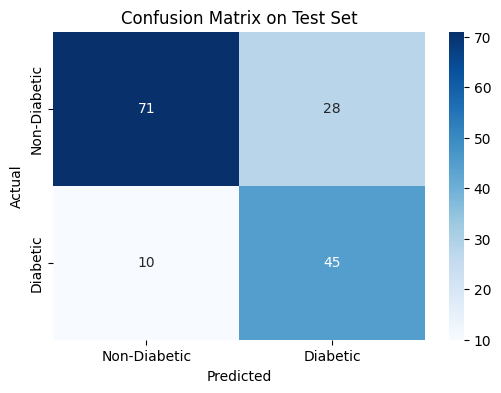

In [15]:
# Confusion Matrix
y_test_pred = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Diabetic", "Diabetic"], yticklabels=["Non-Diabetic", "Diabetic"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set")
plt.show()


In [16]:
# Three-way decision function
# Feature column names used during model training
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
           'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
def predict_with_threshold(model, scaler, input_data):
    # Convert input to DataFrame with column names
    input_df = pd.DataFrame([input_data], columns=columns)

    # Scale the input
    input_scaled = scaler.transform(input_df)

    # Predict probability
    prob = model.predict_proba(input_scaled)[0][1]

    # Return diagnosis based on probability
    if prob > 0.55:
        return f"🟢 Positive: The person has diabetes with a probability of {prob:.4f}"
    elif 0.45 <= prob <= 0.55:
        return f"🟡 Uncertain: Borderline case with a probability of {prob:.4f}, further tests recommended"
    else:
        return f"🔴 Negative: The person does not have diabetes with a probability of {prob:.4f}"

In [17]:
# Load model and scaler
with open("diabetes_model.pkl", "rb") as f:
    model = pickle.load(f)

with open("diabetes_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# Test cases
positive_input = [6, 148, 72, 35, 100, 33.6, 0.627, 50]
negative_input = [1, 85, 66, 29, 0, 26.6, 0.351, 31]
uncertain_input = [3, 110, 65, 25, 94, 28.1, 0.5, 40]

# Make predictions
print("✅ Positive Case Test:")
print(predict_with_threshold(model, scaler, positive_input))

print("\n✅ Negative Case Test:")
print(predict_with_threshold(model, scaler, negative_input))

print("\n✅ Uncertain Case Test:")
print(predict_with_threshold(model, scaler, uncertain_input))

✅ Positive Case Test:
🟢 Positive: The person has diabetes with a probability of 0.8300

✅ Negative Case Test:
🔴 Negative: The person does not have diabetes with a probability of 0.0300

✅ Uncertain Case Test:
🔴 Negative: The person does not have diabetes with a probability of 0.3600
